# Momentum resolution of a tracking detector

## Moment resolution

### Setup
The experimental apparatus is constructed with the z-axis horizontal, the x-axis vertical and the y-axis perpendicular to the drawing of the experiment (i.e. exiting the screen).
z positive to the right, x positive upwards and y positive exiting in the direction of the person looking at the drawing.

The experiment setup consists of five detection planes placed along the z-axis, parallel to the x-axis, and placed 2cm apart.
The magnetic field is directed towards the positive y-axis, with an intensity of 0.5T, and is 10cm long along the z-axis. At the end of the magnetic field
there are three detection planes, also parallel to the x-axis and placed 2cm apart.

In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.constants as const

In [2]:
# Variables
n_beforeB = 5              # number of detections planes before the magnetic field
n_afterB = 3               # number of detections planes after the magnetic field
D_z = 2e-2                 # distance between the two planes along z-axis in cm
L = 10e-2                  # length of the magnetic field along z_axis in cm
B = 0.5                    # magnetic field intensity in T
cell_width = 0.0005        # 500 micrometers in metres
z_start_after_B = n_beforeB*D_z + L      # position of the first plane after B field in m

# Constants
q = const.e                # charge of the electron in CC

In [3]:
# Functions

def trajectory_before_B(z, starting_xpoint, starting_angle):
    return starting_xpoint + np.tan(starting_angle) * z

def trajectory_before_B_linear(z, starting_xpoint, slope): 
    return starting_xpoint + z * slope
def generating_x0(n):
    mean_x = 0
    std_x = 1e-3             # m
    x0 = []
    # Generate n random starting positions
    for i in range(n):
        x0.append(stats.norm.rvs(loc=mean_x, scale=std_x))
    return x0

def generating_s0(n):
    mean_s = 0
    std_s = 0.1             # rad
    s0 = []
    # Generate n random angles
    for i in range(n):
        s0.append(stats.norm.rvs(loc=mean_s, scale=std_s))
    return s0

""" Computes and returns the points of the circular path given the starting point, radius, length along z-axis and slope of the first line."""
def circular_path_coefficients(x_start, z_start, radius, L, slope_first_line):
    
    # Radiant angle
    theta = L / radius  # in rad
    
    # Circle center coordinates
    if slope_first_line > 0:
        z_center = z_start + radius * np.sin(np.arctan(slope_first_line))
        x_center = x_start - radius * np.cos(np.arctan(slope_first_line))
    else:
        z_center = z_start - radius * np.sin(np.arctan(slope_first_line))
        x_center = x_start + radius * np.cos(np.arctan(slope_first_line))
        
    # Arc's initial and final points
    theta_start = np.arctan2(x_start - x_center, z_start - z_center)
    theta_end = theta_start - np.sign(slope_first_line)*theta           # the "sign" term is necessary to determine the direction of the arc; initially was only "+", but for positive slopes the arc went backwards 

    # Circular path's points
    theta_arc = np.linspace(theta_start, theta_end, 100)
    z_arc = z_center + radius * np.cos(theta_arc)
    x_arc = x_center + radius * np.sin(theta_arc)
    
    # Return the points of the arc
    return z_arc, x_arc
""" Computes and returns the center coordinates of the circular path given the starting point, radius and slope of the first line."""
def circular_path_center_coordinates(x_start, z_start, radius, slope_first_line):
    
    # Circle center coordinates
    if slope_first_line > 0:
        z_center = z_start + radius * np.sin(np.arctan(slope_first_line))
        x_center = x_start - radius * np.cos(np.arctan(slope_first_line))
    else:
        z_center = z_start - radius * np.sin(np.arctan(slope_first_line))
        x_center = x_start + radius * np.cos(np.arctan(slope_first_line))
    
    # Return the points of the arc
    return z_center, x_center

def starting_angle_after_B(starting_zpoint, starting_xpoint, z_center, x_center):
    # Calculate the slope of the line after the magnetic field
    slope_after_B = -1/ ((starting_xpoint - x_center) / (starting_zpoint - z_center))
    return np.arctan(slope_after_B)
def trajectory_after_B(z, starting_xpoint, starting_angle):
    return starting_xpoint + np.tan(starting_angle) * (z - 0.2)

def trajectory_after_B_linear(z, starting_xpoint, slope): 
    return starting_xpoint + z * slope

def compute_pT_reco(angle_before_B_field, angle_after_B_field, angle_before_B_field_err, angle_after_B_field_err, q):
    theta = angle_after_B_field - angle_before_B_field
    pT_reco = np.abs((q * B * L) / theta)
    # Error propagation for pT_reco
    pT_reco_err = np.sqrt((angle_before_B_field_err * (q * B * L) / theta**2)**2 + (angle_after_B_field_err * (q * B * L) / theta**2)**2)
    return pT_reco, pT_reco_err

# TODO: Change the function name to something more descriptive
def TODO_CHANGE_FUN_NAME(nr_trajectories):
    
    plot_circular_path = True
    
    q = np.random.choice([-1, 1])
    p_T = 0.3e9 / const.c
    curvature_radius = p_T / (q * B)
    
    nr_trajectories = nr_trajectories
    x0 = generating_x0(nr_trajectories)
    s0 = generating_s0(nr_trajectories)
    m_before_B = np.tan(s0)                                 # slopes
    
    # Returning values (lists)
    z_positions_before_B_list = []
    z_positions_after_B_list = []
    x_positions_before_B_list = []
    x_positions_after_B_list = []
    grid_before_B_list = []
    grid_after_B_list = []
    true_traj_z_before_B_list = []
    true_traj_z_after_B_list = []
    reco_traj_z_before_B_list = []
    reco_traj_z_after_B_list = []
    cells_hit_middle_before_B_list = []
    cells_hit_middle_after_B_list = []
    std_hit_list = []
    s_after_B_list = []
    std_x0_reco_before_B_list = []
    std_s0_reco_before_B_list = []
    std_x0_reco_after_B_list = []
    std_s0_reco_after_B_list = []
    

    for i in range(nr_trajectories):
        x0_true = x0[i]             # x0 is a list, the element is the float value
        s0_true = s0[i]             # s0 is a list, the element is the float value

        # Calculate the z and x positions of the planes 
        # To use curve_fit, we need to have a function defined, so we use a function to calculate the x_positions
        z_positions_before_B = np.arange(1, n_beforeB + 1) * D_z
        slope_true = np.tan(s0_true)
        x_positions_before_B = trajectory_before_B_linear(z_positions_before_B, x0_true, slope_true)
        #x_positions_before_B = trajectory_before_B(z_positions_before_B, x0_true, s0_true)

        z_positions_after_B = np.arange(10, n_afterB + 10) * D_z                                                # positions in z after the magnetic field
        z0 = n_beforeB * D_z                # z coordinate of the starting point of the arc
        x0_arc = x0_true + m_before_B * z0       # x coordinates of the starting point of the arc
        z_arc, x_arc = circular_path_coefficients(x0_arc[i], z0, curvature_radius, L, m_before_B[i])
        if plot_circular_path:
            plt.plot(z_arc, x_arc*1000, label="Magnetic field B", linestyle='-', color="purple")
        z_center, x_center = circular_path_center_coordinates(x0_arc[0], z0, curvature_radius, m_before_B[i])
        s_after_B = starting_angle_after_B(z_arc[-1], x_arc[-1], z_center, x_center) 
        x_positions_after_B = trajectory_after_B(z_positions_after_B,x_arc[-1], s_after_B)                      # positions in z after the magnetic field

        # Calculate which cell was hit
        cells_hit_before_B = np.floor(x_positions_before_B / cell_width)
        cells_hit_middle_before_B = cells_hit_before_B * cell_width + cell_width / 2
        cells_hit_after_B = np.floor(x_positions_after_B / cell_width)
        cells_hit_middle_after_B = cells_hit_after_B * cell_width + cell_width / 2
        # Calculate the uncertainty
        std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia
        
        
        # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
        popt_before_B, pcov_before_B = curve_fit(trajectory_before_B_linear, z_positions_before_B, cells_hit_middle_before_B, p0 = None, sigma = std_hit, absolute_sigma = True)
        popt_after_B, pcov_after_B = curve_fit(trajectory_after_B_linear, z_positions_after_B, cells_hit_middle_after_B, p0 = None, sigma = std_hit, absolute_sigma = True)

        x0_reco_before_B, slope_reco_before_B = popt_before_B
        std_x0_reco_before_B, std_slope_reco_before_B = np.sqrt(np.diag(pcov_before_B)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)

        x0_reco_after_B, slope_reco_after_B = popt_after_B
        std_x0_reco_after_B, std_slope_reco_after_B = np.sqrt(np.diag(pcov_after_B))

        s0_reco_before_B = np.arctan(slope_reco_before_B)
        s0_reco_after_B = np.arctan(slope_reco_after_B)

        # We now do error propagation by using y = f(x) -> sigma_y = abs(df/dx (x_mean)) * sigma_x
        std_s0_reco_before_B = std_slope_reco_before_B / (1 + slope_reco_before_B**2) 
        std_s0_reco_after_B = std_slope_reco_after_B / (1 + slope_reco_after_B**2) 
        
        # Plotting details
        grid_before_B = np.linspace(0, z_positions_before_B[-1] + D_z/2, num = 1001)
        true_traj_z_before_B = trajectory_before_B(grid_before_B, x0_true, s0_true)
        reco_traj_z_before_B = trajectory_after_B_linear(grid_before_B, x0_reco_before_B, slope_reco_before_B)

        grid_after_B = np.linspace(z_positions_after_B[0], z_positions_after_B[-1] + D_z/2, num=1001)
        true_traj_z_after_B = trajectory_after_B(grid_after_B, x_arc[-1], s_after_B)
        reco_traj_z_after_B = trajectory_after_B_linear(grid_after_B, x0_reco_after_B, slope_reco_after_B)
        
        # Appending the values to the lists
        z_positions_before_B_list.append(z_positions_before_B)
        z_positions_after_B_list.append(z_positions_after_B)
        x_positions_before_B_list.append(x_positions_before_B)
        x_positions_after_B_list.append(x_positions_after_B)
        grid_before_B_list.append(grid_before_B)
        grid_after_B_list.append(grid_after_B)
        true_traj_z_before_B_list.append(true_traj_z_before_B)
        true_traj_z_after_B_list.append(true_traj_z_after_B)
        reco_traj_z_before_B_list.append(reco_traj_z_before_B)
        reco_traj_z_after_B_list.append(reco_traj_z_after_B)
        cells_hit_middle_before_B_list.append(cells_hit_middle_before_B)
        cells_hit_middle_after_B_list.append(cells_hit_middle_after_B)
        std_hit_list.append(std_hit)
        s_after_B_list.append(s_after_B)
        std_x0_reco_before_B_list.append(std_x0_reco_before_B)
        std_s0_reco_before_B_list.append(std_s0_reco_before_B)
        std_x0_reco_after_B_list.append(std_x0_reco_after_B)
        std_s0_reco_after_B_list.append(std_s0_reco_after_B)
    
    return (z_positions_before_B_list, z_positions_after_B_list, x_positions_before_B_list, x_positions_after_B_list, grid_before_B_list, grid_after_B_list, true_traj_z_before_B_list, true_traj_z_after_B_list, reco_traj_z_before_B_list, reco_traj_z_after_B_list, cells_hit_middle_before_B_list, cells_hit_middle_after_B_list, std_hit_list, 
            s_after_B_list, std_x0_reco_before_B_list, std_s0_reco_before_B_list, std_x0_reco_after_B_list, std_s0_reco_after_B_list, s0, q)


### Part a), warm-up
As a warm-up exercise, generate a single particle trajectory for a particle with pT = 0.3 GeV, x0 true drawn from a Gaussian distribution with mean 0 and standard deviation 1 mm and with s0 true drawn from a Gaussian distribution with mean 0 and standard deviation 0.1 rad.
Randomly assign charge q = +1 or q = −1 to the particle.
(a) Extrapolate the trajectory to the z positions of the eight detection layers (five before and three after the magnet). Generate hit positions as you did in Sec. 3. Draw the trajectory and the hit positions with their uncertainties.
### Part b)
(b) Fit straight lines to the hits in the stations before and after the magnet and determine pT reco and its uncertainty from the angle between these two lines

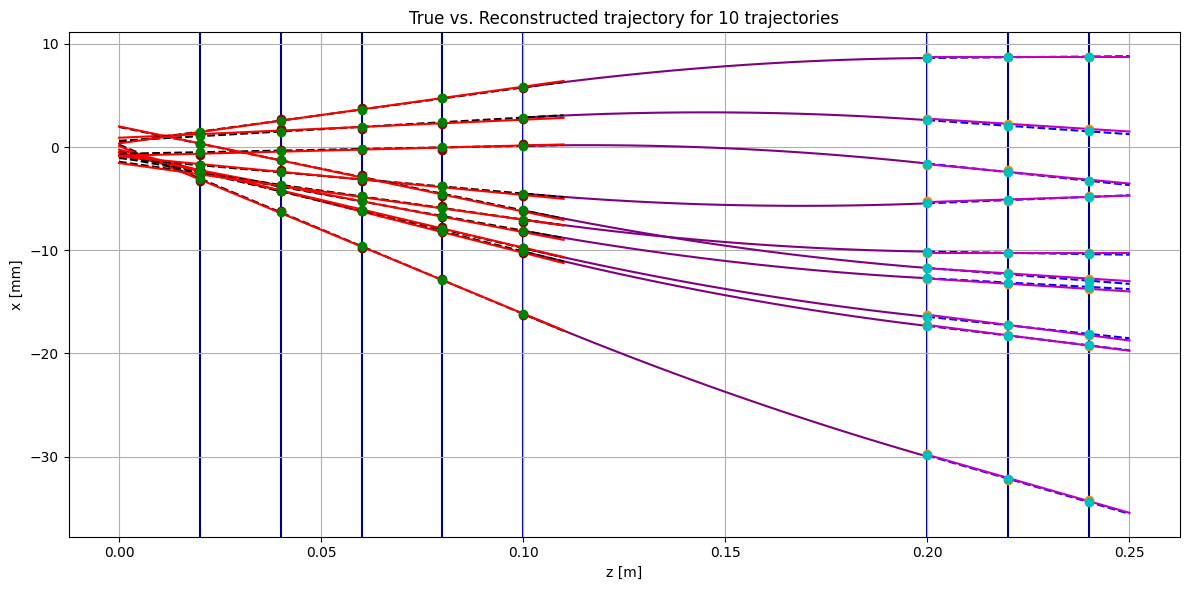

In [4]:
# Part a)
# Warm-up

np.random.seed(14)
plt.figure(figsize=(12,6))
# Specify the numbers of trajectories to be generated
nr_trajectories = 10
z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q = TODO_CHANGE_FUN_NAME(nr_trajectories)


for z in z_positions_before_B[0]:
    plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0)  # Detector planes before B
for z in z_positions_after_B[0]:
    plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0)  # Detector planes after B

for i in range(nr_trajectories):
    
    plt.plot(grid_before_B[i], 1000 * true_traj_z_before_B[i], "k--", label="True, original trajectory before B field")
    plt.plot(grid_before_B[i], 1000 * reco_traj_z_before_B[i], "r-", label="Reconstructed trajectory before B field")
    plt.scatter(z_positions_before_B[i], 1000 * x_positions_before_B[i], color="g", label="True, original hit positions before B field", zorder=3)
    plt.errorbar(z_positions_before_B[i], 1000 * cells_hit_middle_before_B[i], yerr=1000 * std_hit[i], fmt="o", color="darkred", linewidth=2.5, label="Recorded hit positions before B field")

    plt.plot(grid_after_B[i], 1000 * true_traj_z_after_B[i], "b--", label="True, original trajectory after B field")
    plt.plot(grid_after_B[i], 1000 * reco_traj_z_after_B[i], "m-", label="Reconstructed trajectory after B field")
    plt.scatter(z_positions_after_B[i], 1000 * x_positions_after_B[i], color="c", label="True, original hit positions after B field", zorder=3)
    plt.errorbar(z_positions_after_B[i], 1000 * cells_hit_middle_after_B[i], yerr=1000 * std_hit[i], fmt="o", color="darkorange", linewidth=2.5, label="Recorded hit positions after B field")

plt.xlabel("z [m]")
plt.ylabel("x [mm]")
plt.grid()
plt.title(f"True vs. Reconstructed trajectory for {nr_trajectories} trajectories")
plt.tight_layout()
plt.show()
filename = f"proj1_momentum_res_{nr_trajectories}_trajectories.png"
#plt.savefig(filename)
plt.close()

In [5]:
# Compute pT_reco
pT_reco_list = []
pT_reco_err_list = []

for i in range(nr_trajectories):
    pT_reco, pT_reco_err = compute_pT_reco(s0[i], s_after_B[i], std_s0_reco_before_B[i], std_s0_reco_after_B[i], q)
    pT_reco_list.append(pT_reco * const.c / 1e9)
    pT_reco_err_list.append(pT_reco_err * const.c / 1e9)

# Convert the result in GeV
pT_reco_list = np.array(pT_reco_list)   # GeV
pT_reco_err_list = np.array(pT_reco_err_list) # GeV